In [82]:
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import jax.numpy as jnp
import arviz as az
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [83]:
import geopandas as gpd

map_data = gpd.read_file('../../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data = map_data.sort_values(by='shapeName')
map_data = map_data.reset_index(drop=True)
map_data.loc[16, 'shapeName'] = "N'Djamena"
data = pd.read_csv('../../data/panel_data.csv')
data = data.sort_values(by=['state', 'time'])
data = data.reset_index(drop=True)
data['longitude'] = [np.nan]*data.shape[0]
data['latitude'] = [np.nan]*data.shape[0]
data

,time,state,t2m,tp,lai_hv,lai_lv,cases,deaths,longitude,latitude
0,2020-01-01,BAHR EL GAZEL,19.761659,0.001129,0.018409,0.660031,259.0,1.0,NaN,NaN
1,2020-02-01,BAHR EL GAZEL,21.966063,0.001508,0.018410,0.666643,165.0,0.0,NaN,NaN
2,2020-03-01,BAHR EL GAZEL,29.094683,0.000762,0.018419,0.672094,112.0,0.0,NaN,NaN
3,2020-04-01,BAHR EL GAZEL,32.909817,0.000761,0.018420,0.674704,160.0,1.0,NaN,NaN
4,2020-05-01,BAHR EL GAZEL,34.160160,0.006172,0.018420,0.676452,127.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1099,2023-08-01,WADI FIRA,28.563262,1.064246,0.276725,1.037876,3684.0,0.0,NaN,NaN
1100,2023-09-01,WADI FIRA,30.720729,0.231967,0.274975,0.979286,5681.0,0.0,NaN,NaN
1101,2023-10-01,WADI FIRA,30.087666,0.011532,0.271415,0.903648,5281.0,0.0,NaN,NaN
1102,2023-11-01,WADI FIRA,27.235060,0.000475,0.270037,0.882541,3310.0,0.0,NaN,NaN


In [84]:
longitudes, latitudes = [], []
for polygon in map_data['geometry'].values:
    centroid = polygon.centroid
    longitudes.append(centroid.x)
    latitudes.append(centroid.y)

for time in data['time'].unique():
    data.loc[data['time'] == time,'longitude'] = longitudes
    data.loc[data['time'] == time,'latitude'] = latitudes

data

,time,state,t2m,tp,lai_hv,lai_lv,cases,deaths,longitude,latitude
0,2020-01-01,BAHR EL GAZEL,19.761659,0.001129,0.018409,0.660031,259.0,1.0,16.879392,14.550121
1,2020-02-01,BAHR EL GAZEL,21.966063,0.001508,0.018410,0.666643,165.0,0.0,16.879392,14.550121
2,2020-03-01,BAHR EL GAZEL,29.094683,0.000762,0.018419,0.672094,112.0,0.0,16.879392,14.550121
3,2020-04-01,BAHR EL GAZEL,32.909817,0.000761,0.018420,0.674704,160.0,1.0,16.879392,14.550121
4,2020-05-01,BAHR EL GAZEL,34.160160,0.006172,0.018420,0.676452,127.0,0.0,16.879392,14.550121
...,...,...,...,...,...,...,...,...,...,...
1099,2023-08-01,WADI FIRA,28.563262,1.064246,0.276725,1.037876,3684.0,0.0,21.503831,15.029089
1100,2023-09-01,WADI FIRA,30.720729,0.231967,0.274975,0.979286,5681.0,0.0,21.503831,15.029089
1101,2023-10-01,WADI FIRA,30.087666,0.011532,0.271415,0.903648,5281.0,0.0,21.503831,15.029089
1102,2023-11-01,WADI FIRA,27.235060,0.000475,0.270037,0.882541,3310.0,0.0,21.503831,15.029089


In [85]:
data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data['cases'] = data['cases'].astype(int)

data = data.sort_values(by=['state', 'time'])  # Ensure data is sorted
data['lag_cases'] = data.groupby('state')['cases'].shift(1)
data = data.dropna(subset=['lag_cases'])
data = pd.get_dummies(data, columns=['state'], drop_first=False)
states = [element.split('_')[1] for element in data.columns if element.startswith('state')]
data = data.reset_index(drop=True)
data.head()

,time,t2m,tp,lai_hv,lai_lv,cases,deaths,longitude,latitude,month,...,state_MAYO KEBBI EST,state_MAYO KEBBI OUEST,state_MOYEN CHARI,state_NDJAMENA,state_OUADDAI,state_SALAMAT,state_SILA,state_TANDJILE,state_TIBESTI,state_WADI FIRA
0,2020-02-01,21.966063,0.001508,0.018410,0.666643,165,0.0,16.879392,14.550121,2,...,False,False,False,False,False,False,False,False,False,False
1,2020-03-01,29.094683,0.000762,0.018419,0.672094,112,0.0,16.879392,14.550121,3,...,False,False,False,False,False,False,False,False,False,False
2,2020-04-01,32.909817,0.000761,0.018420,0.674704,160,1.0,16.879392,14.550121,4,...,False,False,False,False,False,False,False,False,False,False
3,2020-05-01,34.160160,0.006172,0.018420,0.676452,127,0.0,16.879392,14.550121,5,...,False,False,False,False,False,False,False,False,False,False
4,2020-06-01,34.258059,0.059696,0.018422,0.686095,83,0.0,16.879392,14.550121,6,...,False,False,False,False,False,False,False,False,False,False


In [86]:
data.columns

Index(['time', 't2m', 'tp', 'lai_hv', 'lai_lv', 'cases', 'deaths', 'longitude',
       'latitude', 'month', 'year', 'lag_cases', 'state_BAHR EL GAZEL',
       'state_BATHA', 'state_BORKOU', 'state_CHARI BAGUIRMI',
       'state_ENNEDI EST', 'state_ENNEDI OUEST', 'state_GUERA',
       'state_HADJER LAMIS', 'state_KANEM', 'state_LAC',
       'state_LOGONE OCCIDENTAL', 'state_LOGONE ORIENTAL', 'state_MANDOUL',
       'state_MAYO KEBBI EST', 'state_MAYO KEBBI OUEST', 'state_MOYEN CHARI',
       'state_NDJAMENA', 'state_OUADDAI', 'state_SALAMAT', 'state_SILA',
       'state_TANDJILE', 'state_TIBESTI', 'state_WADI FIRA'],
      dtype='object')

In [87]:
data_test = data[data['time']>'2023-06-01']
X_test = jnp.array(data_test[['lag_cases','t2m', 'tp','longitude','latitude','month'] + [col for col in data_test.columns if col.startswith('state_') ]].values.tolist())
y_test = jnp.array(data_test['cases'].values.astype(int).tolist())

In [88]:
data_train = data[data['time']<='2023-06-01']
X_train = jnp.array(data_train[['lag_cases','t2m', 'tp','longitude','latitude','month'] + [col for col in data_test.columns if col.startswith('state_') ]].values.tolist())
y_train = jnp.array(data_train['cases'].values.astype(int).tolist())

In [114]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from jax import random

def panel_model(X, y=None):
    # Priors for coefficients
    beta_t2m = numpyro.sample('beta_t2m', dist.Normal(25, 5.0))
    beta_tp = numpyro.sample('beta_tp', dist.Normal(0, 1.0))
    beta_state = numpyro.sample('beta_state', dist.Normal(100, 10.0).expand([23]))
    beta_lag = numpyro.sample('beta_lag', dist.Normal(0, 1.0))
    
    # Priors for seasonal (sine/cosine) terms
    beta_sin = numpyro.sample('beta_sin', dist.Normal(0, 1.0))
    beta_cos = numpyro.sample('beta_cos', dist.Normal(0, 1.0))
    
    # Priors for spatial terms (latitude/longitude)
    beta_lat = numpyro.sample('beta_lat', dist.Normal(0, 1.0))
    beta_lon = numpyro.sample('beta_lon', dist.Normal(0, 1.0))
    
    # Linear combination
    mu_lag = jnp.dot(X[:, 0], beta_lag)
    mu_t2m = jnp.dot(X[:, 1], beta_t2m)
    mu_tp = jnp.dot(X[:, 2], beta_tp)
    mu_state = jnp.dot(X[:, 6:29], beta_state)
    
    # Seasonality (sine/cosine of the month)
    month = X[:, 5]
    mu_seasonal = beta_sin * jnp.sin(2 * jnp.pi * month / 12) + beta_cos * jnp.cos(2 * jnp.pi * month / 12)
    
    # Spatial effects (latitude and longitude)
    lat = X[:, 4]
    lon = X[:, 3]
    mu_spatial = beta_lat * lat + beta_lon * lon
    
    # Total effect
    mu = numpyro.deterministic('mu', jnp.abs(mu_t2m + mu_tp + mu_lag + mu_state + mu_seasonal + mu_spatial))
    
    # sigma
    sigma = numpyro.sample('sigma', dist.HalfNormal(1.0))
    
    # Likelihood
    # numpyro.sample('obs', dist.Poisson(mu), obs=y)
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=y) 

# Run MCMC to sample from the posterior
nuts_kernel = NUTS(panel_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500)
rng_key = random.PRNGKey(0)

# Assuming you have the following data arrays:
# X_train: features (t2m, tp, etc.), lat_train: latitude, lon_train: longitude, month_train: month (in numerical form)
mcmc.run(rng_key, X=X_train, y=y_train)

# Summarize the results
mcmc.print_summary()


sample: 100%|██████████| 1500/1500 [00:20<00:00, 72.27it/s, 15 steps of size 1.78e-01. acc. prob=0.94] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_cos     -7.40      0.99     -7.38     -9.05     -5.84   1688.27      1.00
      beta_lag      0.90      0.00      0.90      0.89      0.90    784.15      1.00
      beta_lat     -8.79      0.91     -8.75    -10.16     -7.22   1482.36      1.00
      beta_lon     -0.46      0.91     -0.46     -2.07      0.93   1509.88      1.00
      beta_sin     -5.31      0.96     -5.31     -6.79     -3.69   2513.00      1.00
 beta_state[0]     81.34     10.12     81.41     64.80     98.82   2139.83      1.00
 beta_state[1]     92.50     10.08     92.68     76.35    110.17   1822.24      1.00
 beta_state[2]     78.45     10.20     78.50     61.45     95.27   1717.34      1.00
 beta_state[3]     92.02      9.63     91.17     75.76    107.47   1403.73      1.00
 beta_state[4]     84.66      9.78     84.34     68.27    100.65   2299.01      1.00
 beta_state[5]     80.84      9.55     81.09     63.67     94.44

/tmp/ipykernel_21424/3017634954.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  map_data['shapeName'][21] = "N'Djamena"
/tmp/ipykernel_21424/3017634954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

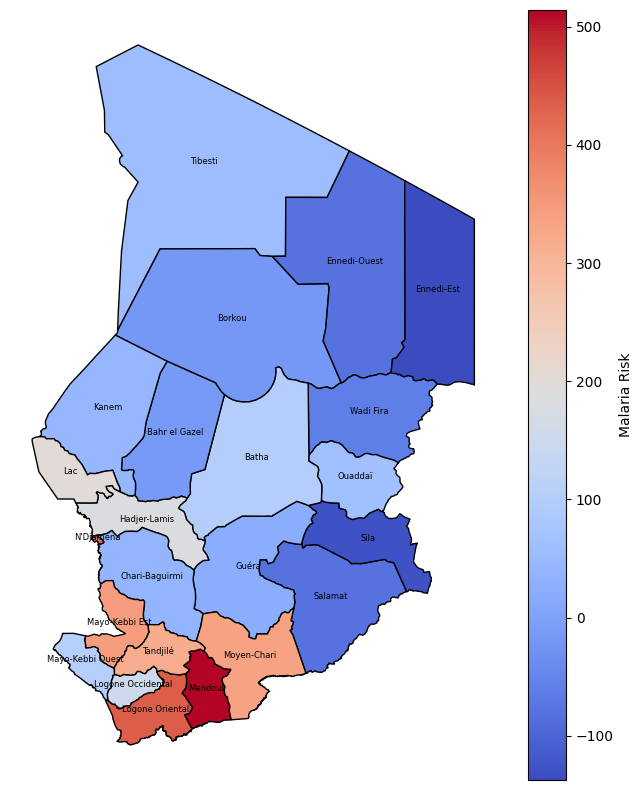

In [93]:
import cartopy.crs as ccrs
import geopandas as gpd

samples = mcmc.get_samples()
map_data = gpd.read_file('../../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data['shapeName'][21] = "N'Djamena"
shape_names = map_data['shapeName'].tolist()
shape_names.sort()
map_data['risk'] = [None]*23
for element in shape_names:
    map_data.loc[map_data['shapeName']==element, 'risk'] = samples['beta_state'][:, shape_names.index(element)].mean()
map_data['risk'] = pd.to_numeric(map_data['risk'], errors='coerce')
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# ax = plt.axes(projection=ccrs.PlateCarree())
map_data.plot(edgecolor='black', column='risk', cmap='coolwarm', ax=ax, legend=True,
              legend_kwds={'label': "Malaria Risk", 'orientation': "vertical"})
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['shapeName']):
    ax.annotate(label, xy=(x, y), fontsize=6, ha='center')
plt.axis('off')
plt.savefig('../../docs/risk-scores.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

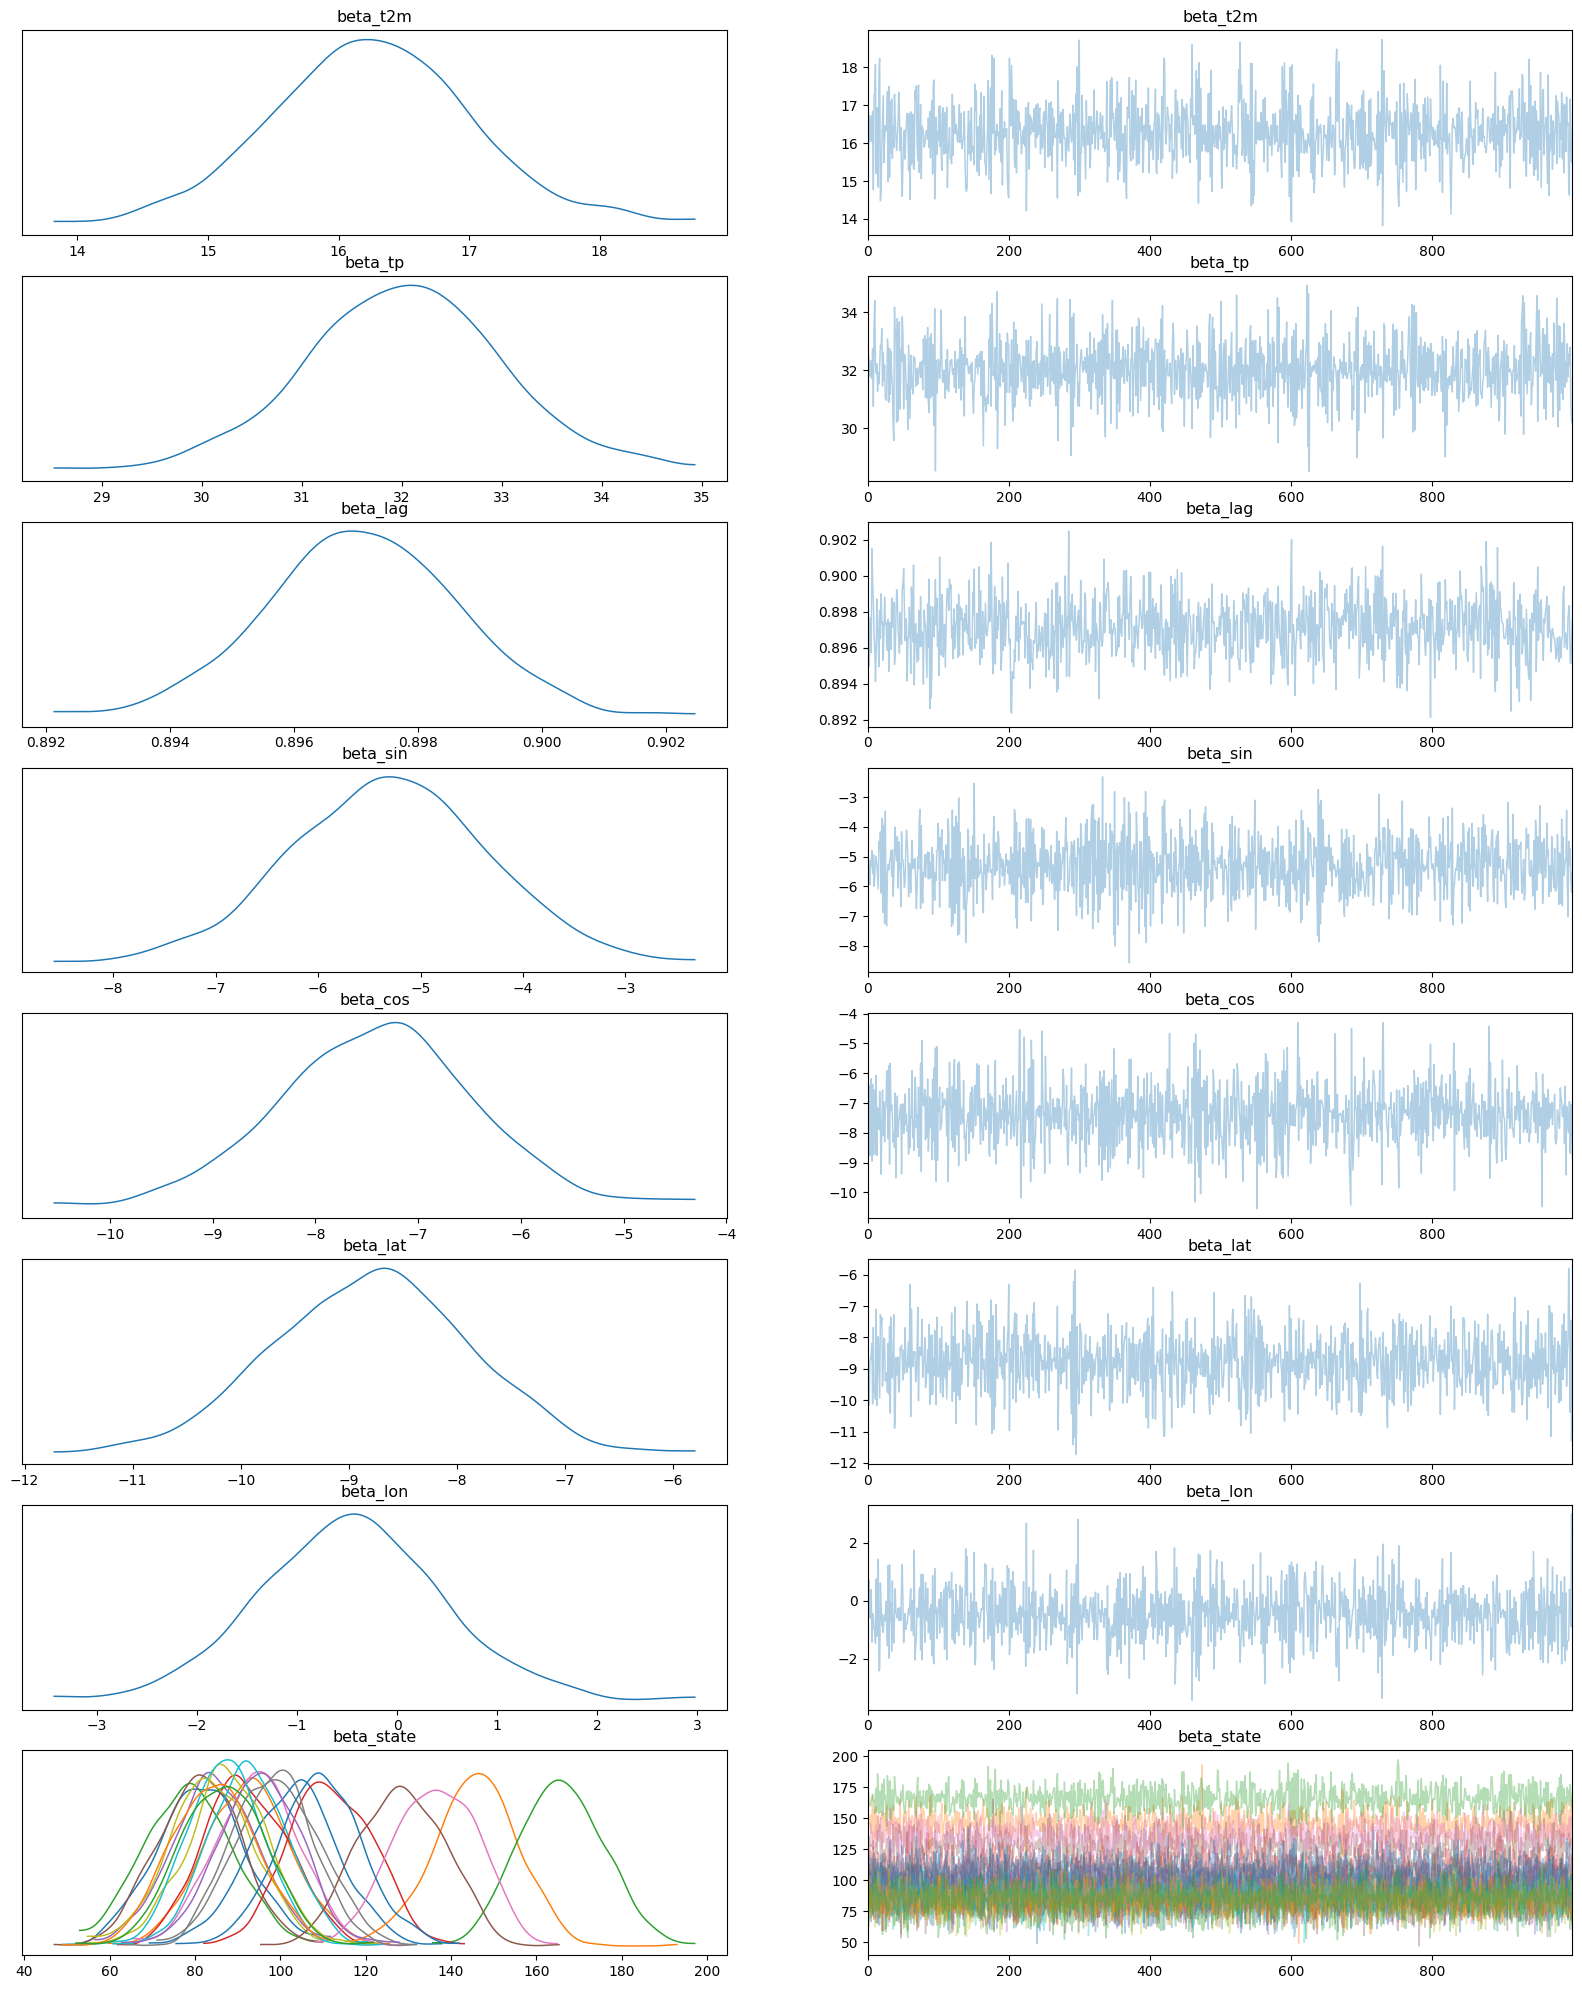

In [115]:
idata = az.from_numpyro(mcmc)
az.rcParams['plot.max_subplots'] = 200
az.plot_trace(idata, compact=True, figsize=(20,25), kind='trace', var_names=["beta_t2m", 'beta_tp', 'beta_lag','beta_sin', 'beta_cos','beta_lat', 'beta_lon' , 'beta_state'])
plt.savefig('../../docs/trace_plot.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

## Calculate WAIC and LOO-CV

In [50]:
waic = az.waic(idata)
loo = az.loo(idata)

print('WAIC:', waic)
print('LOO-CV:', loo)

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC: Computed from 10000 posterior samples and 943 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -268934.18  28314.02
p_waic     7360.81        -

There has been a warning during the calculation. Please check the results.
LOO-CV: Computed from 10000 posterior samples and 943 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -266667.39  27712.91
p_loo     5094.03        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      703   74.5%
   (0.70, 1]   (bad)        92    9.8%
   (1, Inf)   (very bad)  148   15.7%



/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


## Pred vs. original

In [118]:
def predict(X, model, key):
    _, rng_key_ = random.split(key)
    samples_1 = model.get_samples()
    predictive = Predictive(panel_model, samples_1)
    posterior_predictions = predictive(rng_key_, X=X)
    post_obs = posterior_predictions['obs']
    mean_post_pred = jnp.mean(post_obs, axis=0)
    hpdi_post_pred = hpdi(post_obs, 0.99)
    
    return mean_post_pred, hpdi_post_pred

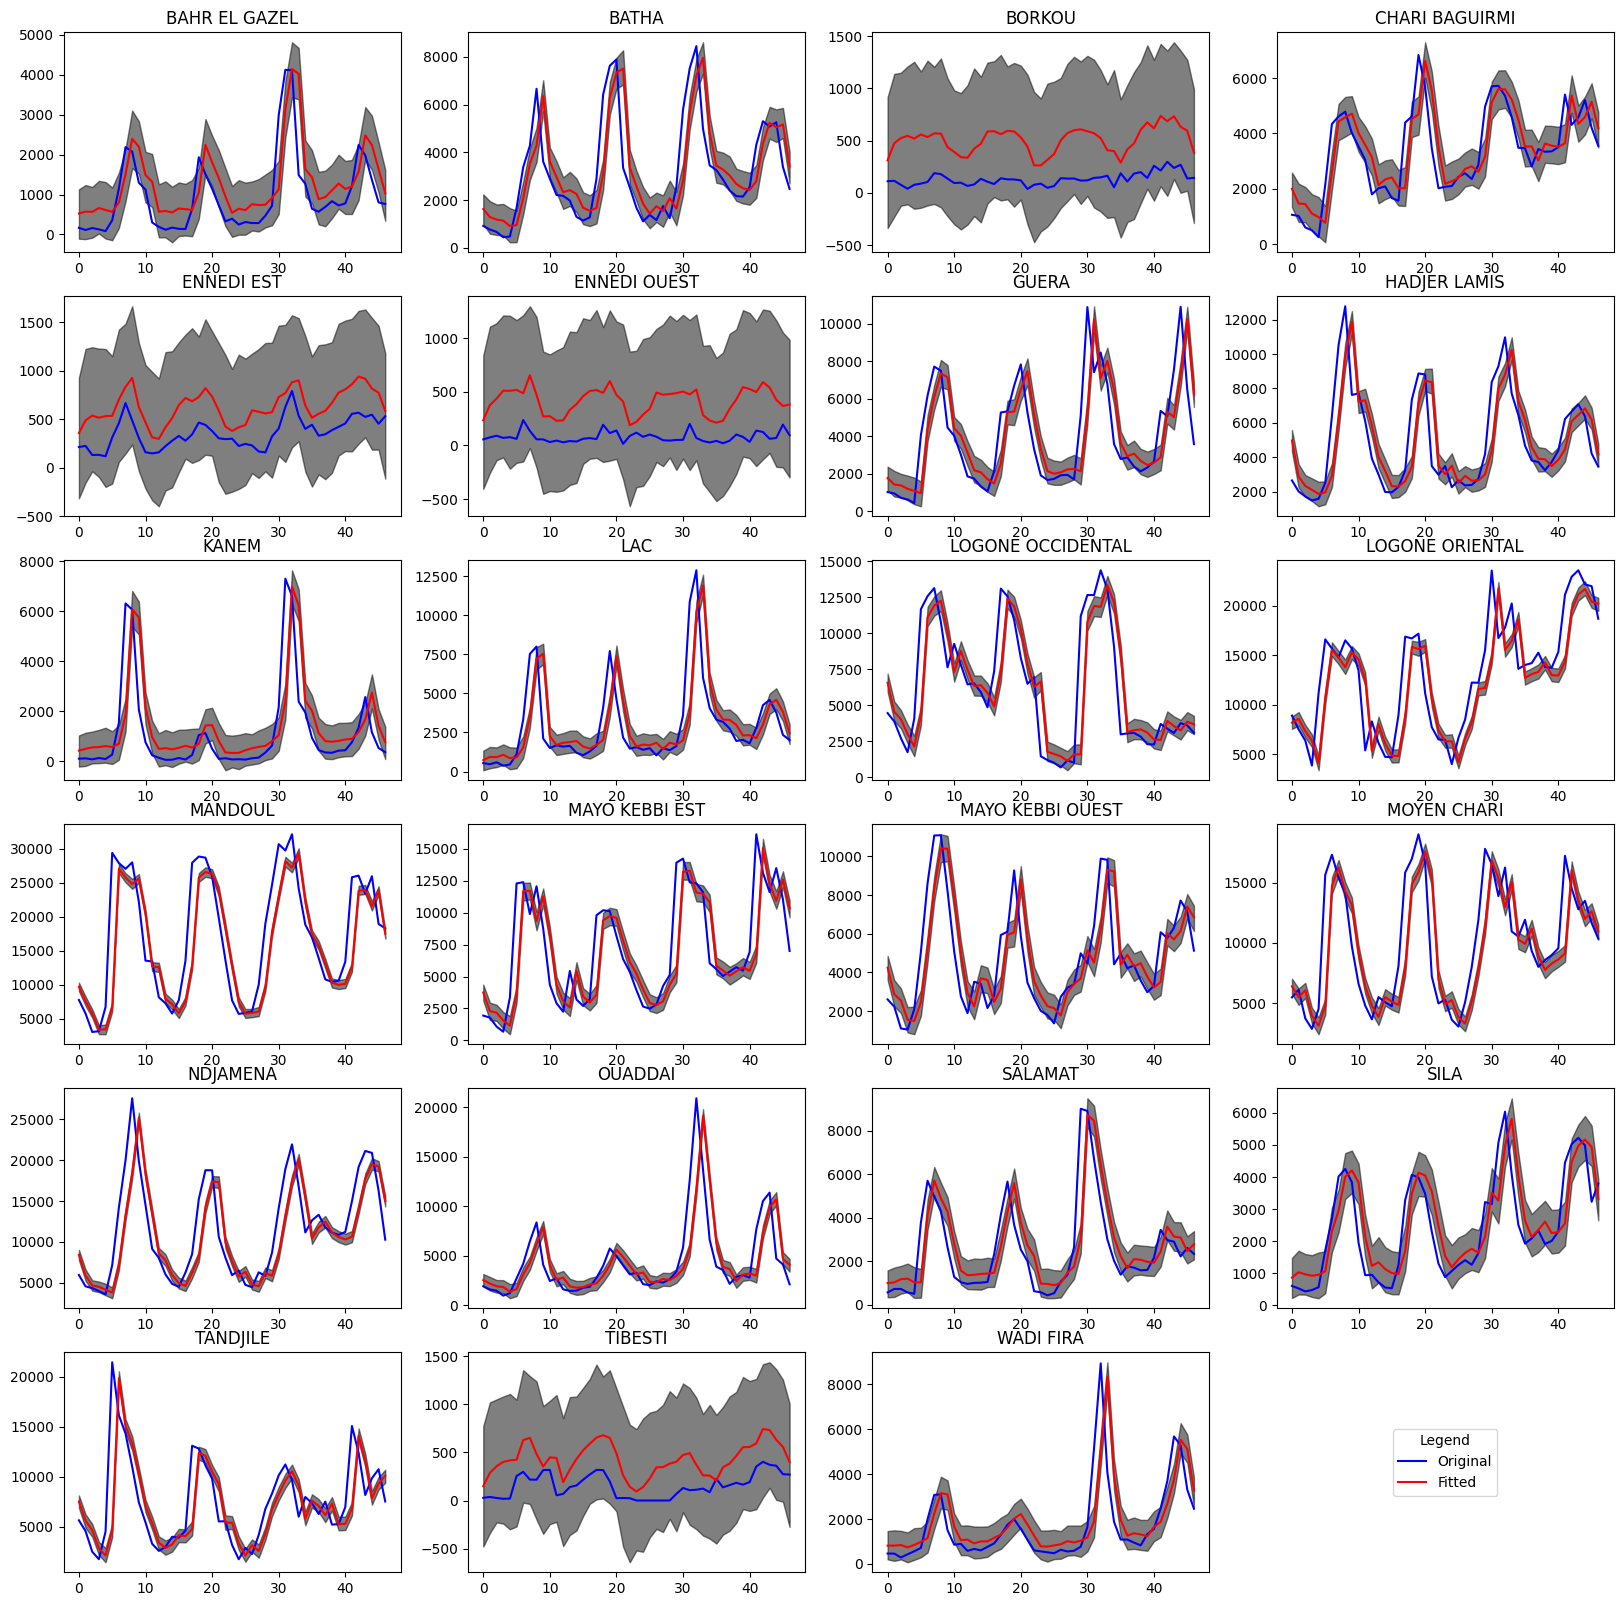

In [120]:
X = jnp.array(data[['lag_cases','t2m', 'tp','longitude','latitude','month'] + [col for col in data_test.columns if col.startswith('state_') ]].values.tolist())
y = jnp.array(data['cases'].values.astype(int).tolist())

fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred, hpdi_post_pred = predict(X[X[:,6+i]==1], mcmc, rng_key)
    axes[idx,idy].plot(y[X[:,6+i]==1], label='Original', color='blue')
    axes[idx,idy].plot(mean_post_pred, label='Fitted', color='red')
    axes[idx,idy].fill_between(xticks, hpdi_post_pred[0], hpdi_post_pred[1], color='black', alpha=0.5)
    axes[idx,idy].set_title(states[i])

axes[5, 3].clear()
axes[5, 3].axis('off')
handles, labels = axes[0, 0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.5), bbox_transform=axes[5, 3].transAxes, title='Legend')

# plt.savefig('../../docs/predictions.png', bbox_inches='tight', pad_inches=0.0)

## Residuals plot

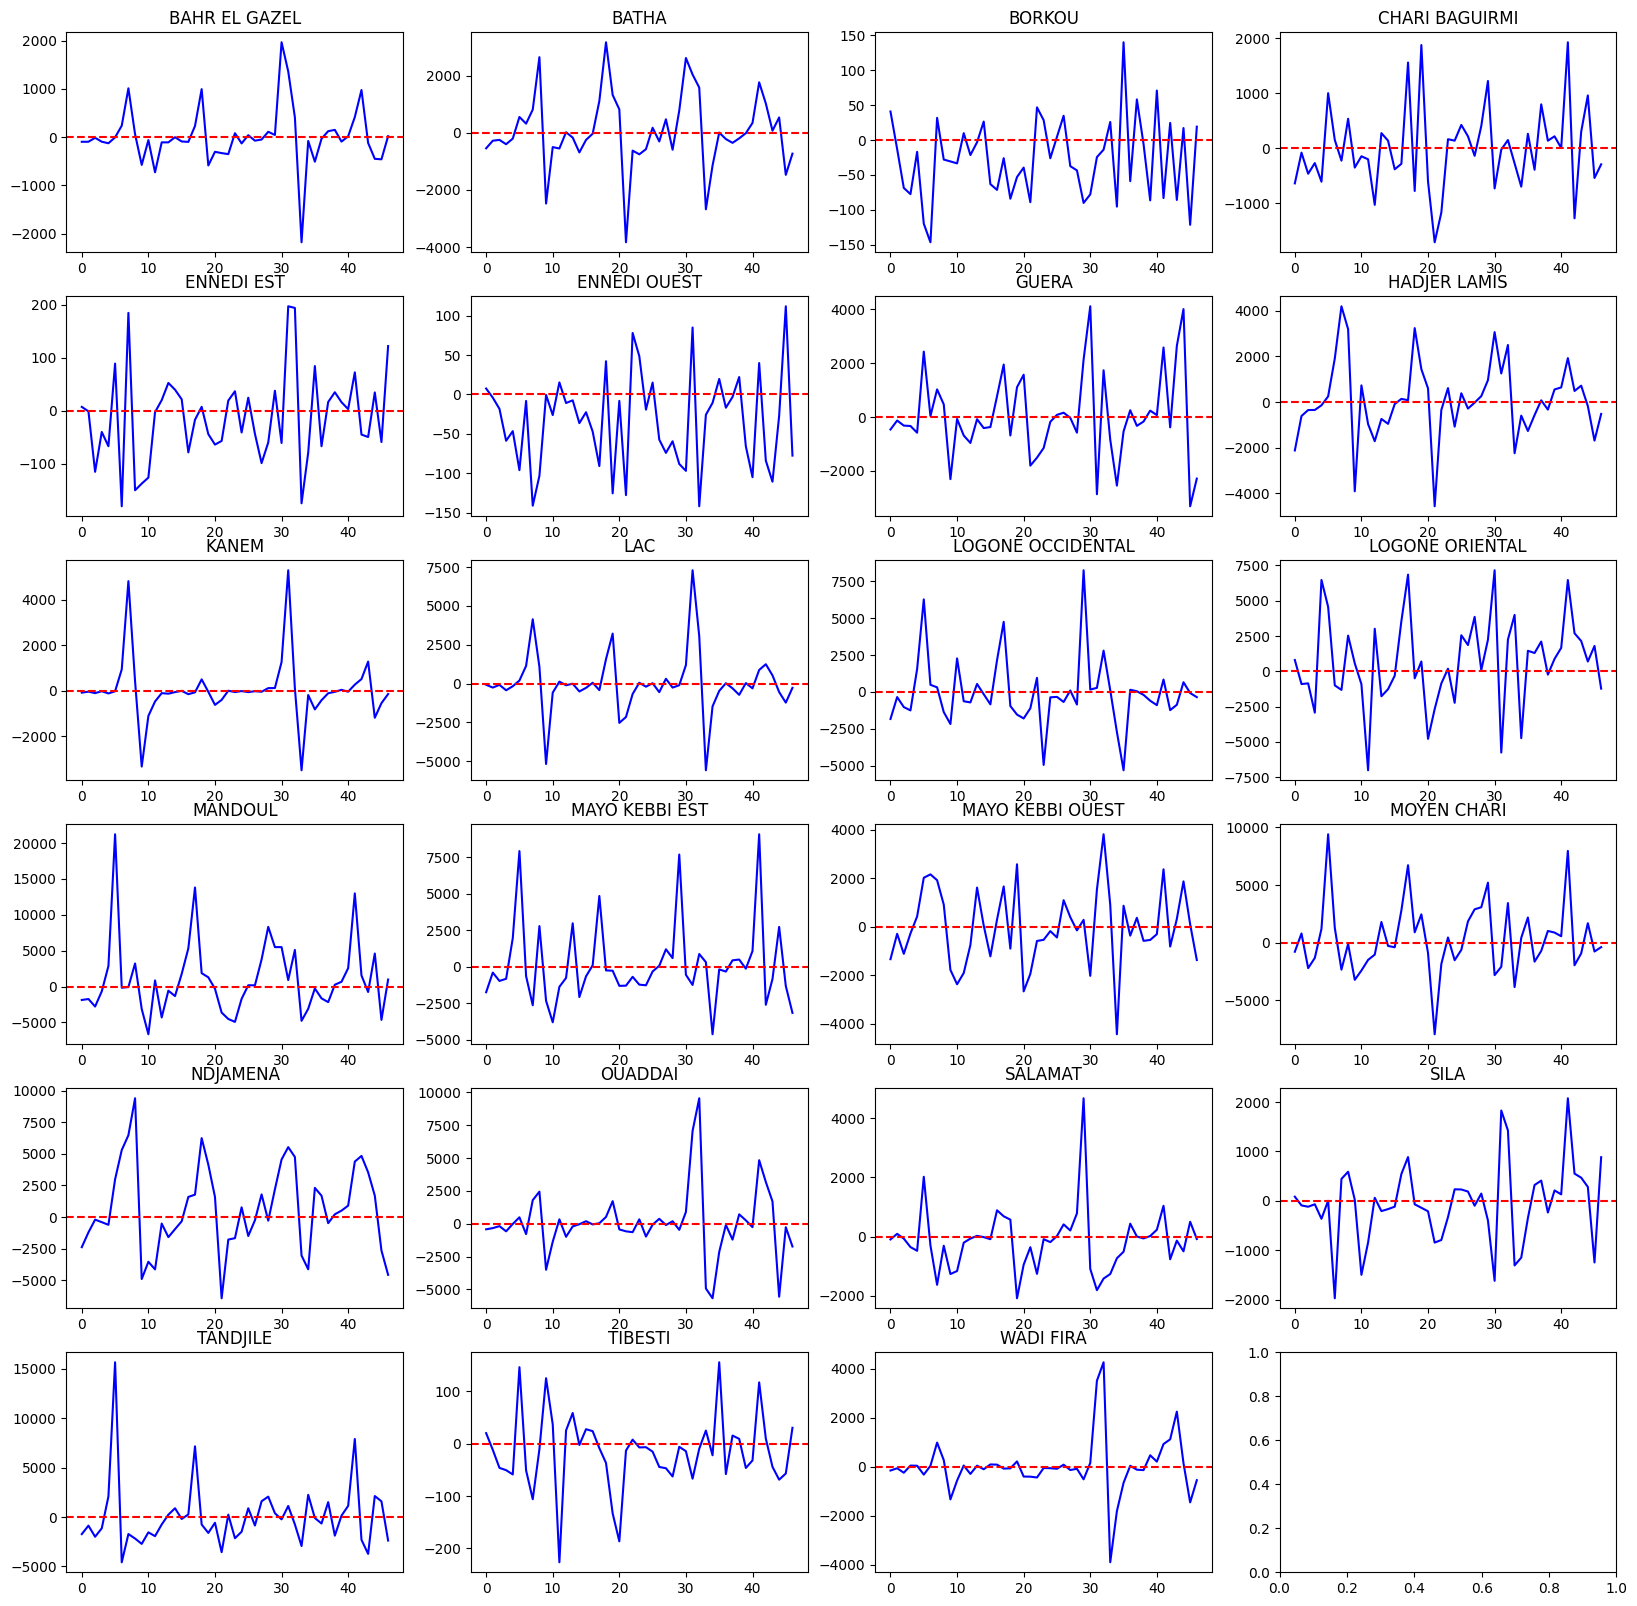

In [53]:
fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred, hpdi_post_pred = predict(X[X[:,3+i]==1], mcmc, rng_key)
    axes[idx,idy].plot(y[X[:,3+i]==1]-mean_post_pred, label='Original', color='blue')
    axes[idx,idy].axhline(0, color='red', linestyle='--')
    axes[idx,idy].set_title(states[i])

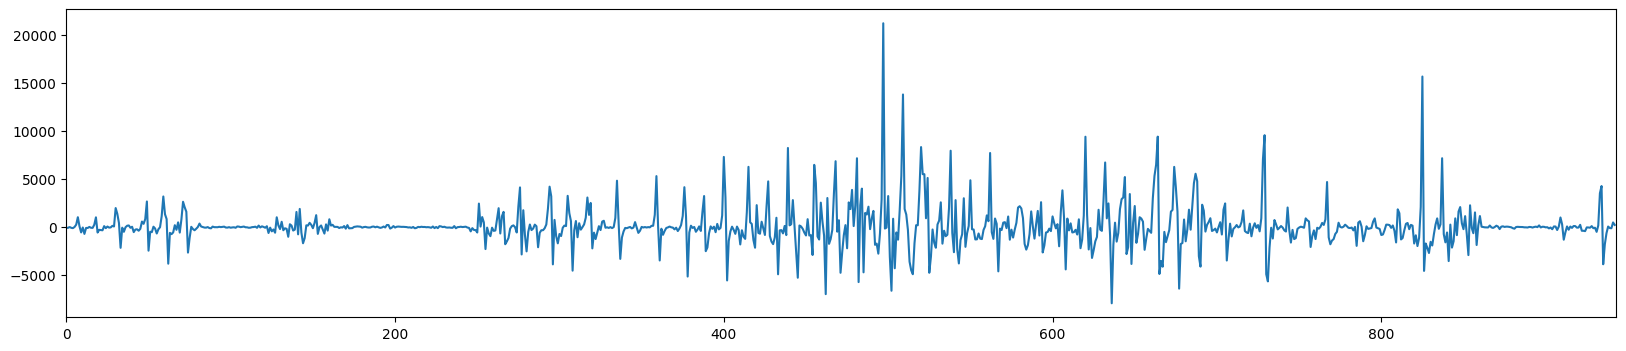

In [54]:
pred_mean, pred_hpdi = predict(X_train, mcmc, rng_key)

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(y_train-pred_mean)
plt.savefig('../../docs/residual_train.png', bbox_inches='tight', pad_inches=0.0)
plt.xlim((0,len(pred_mean)))
plt.show()

## Evaluation metrics

In [111]:
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
samples_1 = mcmc.get_samples()
predictive = Predictive(panel_model, samples_1)
posterior_predictions = predictive(rng_key_, X=X_test)
post_obs = posterior_predictions['obs']

mean_post_pred = round(jnp.mean(post_obs, axis=0))
hpdi_post_pred = hpdi(post_obs, 0.9)

In [112]:
rmse = jnp.sqrt(((y_test - mean_post_pred)**2).mean())
mae = jnp.abs(y_test - mean_post_pred).mean()

ss_total = jnp.var(y_test)
ss_residual = jnp.mean((y_test - mean_post_pred.round()) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print('RMSE:', rmse)
print('MAE:', mae)
print(f'Bayesian R-squared: {r_squared}')

RMSE: 2416.6462
MAE: 1458.7609
Bayesian R-squared: 0.8718526363372803
